# Scraping of Parliament website

## Import Libraries

In [350]:
from bs4 import BeautifulSoup as bs # Note: Hint: suggest using bs for subsequent parsing of HTML source
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import time
import pandas as pd
import requests
import json

## Load Scraper and Scrape Debates

In [351]:
driver = webdriver.Chrome('chromedriver')
page_url = 'https://sprs.parl.gov.sg/search/home'
driver.get(page_url)

# Get search box and fill it up
search = driver.find_element(By.CSS_SELECTOR, '#divmpscreen2 > div.row > div:nth-child(1) > div > div:nth-child(1) > input')
search.send_keys('COMMITTEE OF SUPPLY')

# Uncomment following two lines to only search in titles
checkbox = driver.find_element(By.CSS_SELECTOR, '#divmpscreen2 > div.row > div:nth-child(1) > div > div:nth-child(2) > label > input')
driver.execute_script("arguments[0].scrollIntoView();", checkbox)
try:
    checkbox.click()
except:
    checkbox.click()
# This will select the 13th parliament
session = driver.find_element(By.CSS_SELECTOR, '#divmpscreen2 > div.row > div:nth-child(1) > div > div.form-group.byParText > select > option:nth-child(14)')
session.click()

# Find submit element and click
submit = driver.find_element(By.CSS_SELECTOR, '#divmpscreen2 > div.row > div.col-sm-12.text-right.pull-right > div > button:nth-child(2)')
try:
    submit.click()
except:
    submit.click()
print('Search parameters submitted.')

Search parameters submitted.


In [ ]:
# Create empty dictionary to store results
res_dict = {}

# Switch window and check for number of search results
driver.switch_to.window(driver.window_handles[1])
num_results = driver.find_element(By.CSS_SELECTOR, '#searchResults > div:nth-child(1) > div')
res = num_results.text.split(' ')
num_clicks = int(res[-1]) // int(res[-3]) + 1
print('There are {} pages to click through.'.format(num_clicks))
first_link_height = 0
# Nested for loop to click through all search results
for click in range(num_clicks):
    
    # This assumes that 20 search results are returned, which are 1-indexed in the xpaths
    for item in range (1, 21):
        # Switch to search results page
        driver.switch_to.window(driver.window_handles[1])
        # Get element to click on, to see each individual page with content
        # Last page will have fewer than 20 elements, so need to handle this exception
        try:
            elem = driver.find_element(By.XPATH, '//*[@id="searchResults"]/table/tbody[{}]/tr[1]/td[2]/a'.format(item))
            elem.click()
        except:
            try:
                driver.execute_script(f"window.scrollTo(0, {elem.location['y']+first_link_height})")
                elem.click()
            except:
                break
        if item == 1:
            first_link_height = elem.location['y']
            
        # Switch to page with content and get URL name
        driver.switch_to.window(driver.window_handles[2])
        item_key = driver.current_url.split('/')[-1]
        item_key = item_key.replace('?', '_') # Replace ? because it would be an invalid filename
        
        # Append result to dictionary for later processing
        res_dict[item_key] = driver.page_source
        
        # Write out each page source as a file
        with open(item_key + '.txt', encoding = 'utf-8', mode = 'w+') as file:
            file.write(driver.page_source)
            
        # Close tab
        driver.close()
    # Switch back to search results tab
    driver.switch_to.window(driver.window_handles[1])
    # Click on next page once 20 results have been saved
    # Next page button changes after first 20 results are shown, hence need to enclose the xpath in a try block
    next_btn = driver.find_element(By.XPATH, '/html/body/app-root/app-result/div/div/div[2]/div/div/div/div/div/div[1]/div[3]/section/ul/li[1]/a')
    driver.execute_script("arguments[0].scrollIntoView();", next_btn)
#     WebDriverWait(driver, 5).until(EC.element_to_be_clickable((By.XPATH, '/html/body/app-root/app-result/div/div/div[2]/div/div/div/div/div/div[1]/div[3]/section/ul/li[1]/a'))).click()
    
    button_count = 1
    if click > 0:
        button_count = 3
    try:
        driver.find_element(By.XPATH, f'/html/body/app-root/app-result/div/div/div[2]/div/div/div/div/div/div[1]/div[3]/section/ul/li[{button_count}]/a').click()
    except:
        driver.find_element(By.XPATH, f'/html/body/app-root/app-result/div/div/div[2]/div/div/div/div/div/div[1]/div[3]/section/ul/li[{button_count}]/a').click()
    # Sleep momentarily because next page takes a while to load
    time.sleep(2)
    
# Check that all results are stored
assert len(res_dict.keys()) == int(res[-1]), "It looks like not all the results were stored!"

In [ ]:
with open("scraped_debates.json", "w") as outfile:
    json.dump(res_dict, outfile)

## Parse HTML Content

In [2]:
def getHTMLdocument(url):
      
    response = requests.get(url)
    return response.text

In [3]:
# JSON file
f = open ('scraped_debates.json', "r")
  
# Reading from file
res_dict = json.loads(f.read())

In [5]:
def parse_html_content(res_dict, content_id):
    content = res_dict[content_id]
    soup = bs(content, 'lxml')
    table = soup.find('table')
    if table is None: # Ignore empty html content
        return pd.DataFrame()
        
    debate_metadata = pd.read_html(str(table))[0].set_index(0).T.reset_index(drop=True)    
    debate_metadata['content_id'] = content_id
    debate_metadata.columns = [e.replace(':','') for e in debate_metadata.columns]
    
    # Get text
    paras = soup.find('div', {'class':'reportTable'}).find_all('p')
    para_text = []
    for p in paras:
        tag_names = [e.name for e in p.children]
        if 'span' in tag_names:
            continue # Ignore non-speech
        text = p.text.replace('\xa0', ' ').strip()
        para_text.append(text)
        
    debate_metadata['speech_text'] = '\n'.join(para_text)
    return debate_metadata

In [9]:
debate_df = pd.DataFrame()
for content_id in res_dict.keys():
    cur_debate_df = parse_html_content(res_dict, content_id)
    debate_df = pd.concat([debate_df, cur_debate_df], axis=0)


In [10]:
debate_df

,Parliament No,Session No,Volume No,Sitting No,Sitting Date,Section Name,Title,MPs Speaking,content_id,speech_text
0,13,2,94,130,7-4-2020,Budget,Supplementary Estimates of Expenditure for the...,"[The Chairman, The Chairman, The Second Minist...",sprs3topic_reportid=budget-1371,[Mr Speaker in the Chair]\nThe Chairman: Suppl...
0,13,2,94,126,6-3-2020,Budget,Estimates of Expenditure for the Financial Yea...,NaN,sprs3topic_reportid=budget-1337,[Mr Speaker in the Chair]
0,13,2,94,125,5-3-2020,Budget,Committee of Supply – Head I (Ministry of Soci...,"[The Chairman, Mr Sam Tan Chin Siong, Ms Denis...",sprs3topic_reportid=budget-1331,Mr Seah Kian Peng (Marine Parade): Mr Chairman...
0,13,2,94,125,5-3-2020,Budget,Committee of Supply – Head I (Ministry of Soci...,"[The Chairman, Dr Lily Neo, Mr Desmond Lee, Th...",sprs3topic_reportid=budget-1333,The Senior Parliamentary Secretary to the Mini...
0,13,2,94,125,5-3-2020,Budget,Committee of Supply Reporting Progress,[The Leader of the House (Ms Grace Fu Hai Yien...,sprs3topic_reportid=budget-1334,The Leader of the House (Ms Grace Fu Hai Yien)...
...,...,...,...,...,...,...,...,...,...,...
0,13,1,94,13,6-4-2016,Budget,Committee of Supply – Head P (Ministry of Home...,[The Parliamentary Secretary to the Minister f...,sprs3topic_reportid=budget-703,Mr Christopher de Souza (Holland-Bukit Timah):...
0,13,1,94,13,6-4-2016,Budget,Committee of Supply – Head N (Ministry of Fore...,"[Asst Prof Mahdev Mohan (Nominated Member), Mr...",sprs3topic_reportid=budget-705,"Mr Vikram Nair (Sembawang): Chairman, I beg to..."
0,13,1,94,13,6-4-2016,Budget,Committee of Supply – Head R (Ministry of Law),[Mr Christopher de Souza (Holland-Bukit Timah)...,sprs3topic_reportid=budget-704,Mr Christopher de Souza (Holland-Bukit Timah):...
0,13,1,94,13,6-4-2016,Budget,Estimates of Expenditure for the Financial Yea...,[The Chairman],sprs3topic_reportid=budget-702,[Mdm Speaker in the Chair]\nThe Chairman: Main...


# Data Mining

## Task: The National Archives of Singapore is preparing an exhibition about the evolution of parliamentary debate in Singapore, and wants to do a feature on Committee of Supply (COS) debates in recent years. It has tasked your team to summarise common topics from COS debates that took place within the last Parliament (13th), as well as identify MPs who asked questions frequently about each topic.

In [257]:
# I apologise for the messy function, will reduce repetition given more time.
def split_by_speaker(para, content_id):
    passages = para.split('\n')
    cur_speaker = None
    cur_text = ""
    passage_group = []
    speaker_group = []
    salutations = ['Mr', 'Ms', 'Mrs', 'Mdm', 'Prof', 'Dr']
    
    for passage in passages:
        speaker_check = passage.split(':')
        if len(speaker_check) == 1:
            if cur_speaker is None:
                continue # ignore the first line
            else:
                cur_text += '\n' + passage
        
        else:
            new_speaker = speaker_check[0]
            brac_check = new_speaker.split('(')
            if len(brac_check) > 1: # Check if there's brackets in the text
                if len(set(salutations).intersection(set(new_speaker.split('(')[0].split(' ')))) > 0: # Check if salutation before bracket
                    word = new_speaker.split('(')[0].strip()
                    if ('.' not in word) and (',' not in word) and (len(new_speaker.split(' ')) <= 6):
                        new_speaker = word
                elif len(set(salutations).intersection(set(new_speaker.split('(')[1].split(' ')))) > 0: # Check if salutation after bracket
                    word = new_speaker.split('(')[1].replace(')','').strip()
                    if ('.' not in word) and (',' not in word) and (len(new_speaker.split(' ')) <= 6):
                        new_speaker = word
                        
                else:
                    cur_text += '\n' + passage
                    continue
            else:
                if len(new_speaker.split(' ')) <= 6: # Not more than 6 words
                    if len(set(salutations).intersection(set(new_speaker.split(' ')))) > 0: # Check if there is salutation
                        if ('.' not in new_speaker) and (',' not in new_speaker): 
                            new_speaker = new_speaker.strip()
                
                if new_speaker == speaker_check[0]:
                    cur_text += '\n' + passage
                    continue
                
            if cur_speaker == new_speaker:
                cur_text += '\n' + passage
            else:
                if cur_speaker is not None: # Not the first iteration
                    if len(cur_speaker.split('(')) > 1:     
                        if len(set(salutations).intersection(set(cur_speaker.split('(')[0].split(' ')))) > 0: # Check if salutation before bracket
                            word = cur_speaker.split('(')[0].strip()
                            if ('.' not in word) and (',' not in word) and (len(word.split(' ')) <= 6):
                                speaker_group.append(word)
                            else:
                                speaker_group.append(cur_speaker)
                        elif len(set(salutations).intersection(set(cur_speaker.split('(')[1].split(' ')))) > 0: # Check if salutation after bracket
                            word = cur_speaker.split('(')[1].replace(')','').strip()
                            if ('.' not in word) and (',' not in word) and (len(word.split(' ')) <= 6):
                                speaker_group.append(word)
                            else:
                                speaker_group.append(cur_speaker)
                        else:
                            speaker_group.append(cur_speaker)
                    else:
                        speaker_group.append(cur_speaker)
                    
                    passage_group.append(cur_text)
                cur_speaker = new_speaker
                cur_text = passage.replace(f'{speaker_check[0]}: ', '').strip()
                
    if cur_speaker is None:
        return pd.DataFrame()
    
    if len(cur_speaker.split('(')) > 1:     
        if len(set(salutations).intersection(set(cur_speaker.split('(')[0].split(' ')))) > 0: # Check if salutation before bracket
            word = cur_speaker.split('(')[0].strip()
            if ('.' not in word) and (',' not in word) and (len(word.split(' ')) <= 6):
                speaker_group.append(word)
            else:
                speaker_group.append(cur_speaker)
        elif len(set(salutations).intersection(set(cur_speaker.split('(')[1].split(' ')))) > 0: # Check if salutation after bracket
            word = cur_speaker.split('(')[1].replace(')','').strip()
            if ('.' not in word) and (',' not in word) and (len(word.split(' ')) <= 6):
                speaker_group.append(word)
            else:
                speaker_group.append(cur_speaker)
        else:
            speaker_group.append(cur_speaker)
    else:
        speaker_group.append(cur_speaker)
        
    # Do one-pass cleaning
    last_speaker = speaker_group[0]
    for i in range(1, len(speaker_group))[1:]:
        speaker = speaker_group[i]
        if len(speaker.split(' ')) > 6:
            speaker_group[i] = last_speaker
        else:
            last_speaker = speaker
    
    passage_group.append(cur_text)
    df = pd.DataFrame({'Speaker': speaker_group, 'Passage': passage_group})
    df['content_id'] = content_id
    df['speech_order'] = list(range(1, df.shape[0]+1))
    return df

In [258]:
speech_level_df = pd.DataFrame()
for idx, row in debate_df.iterrows():
    text = row['speech_text']
    content_id = row['content_id']
    temp_speech_df = split_by_speaker(text, content_id)
    speech_level_df = pd.concat([speech_level_df, temp_speech_df], axis=0)

In [354]:
speech_level_df.head()

,Speaker,Passage,content_id,speech_order
0,Ms Indranee Rajah,"Mr Chairman, I beg to move, ""That the total su...",sprs3topic_reportid=budget-1371,1
0,Mr Seah Kian Peng,"Mr Chairman, I beg to move, ""That the total su...",sprs3topic_reportid=budget-1331,1
1,Ms Denise Phua Lay Peng,"Mr Chairman, Singapore's social challenges are...",sprs3topic_reportid=budget-1331,2
2,Assoc Prof Walter Theseira,"Chairman, Singapore was ranked by the Economis...",sprs3topic_reportid=budget-1331,3
3,Mr Mohamed Irshad,"Chairman, this cut concerns food insecurity in...",sprs3topic_reportid=budget-1331,4


In [259]:
debate_speech_level = debate_df.merge(speech_level_df, left_on='content_id', right_on='content_id')

Simple heuristics to count questions \
 \
**Assumptions**:
- Unable to differentiate rheoterical qns and actual qns

In [261]:
debate_speech_level['Question Count'] = debate_speech_level['Passage'].apply(lambda x: x.count('?'))

In [263]:
debate_speech_level.head()

,Parliament No,Session No,Volume No,Sitting No,Sitting Date,Section Name,Title,MPs Speaking,content_id,speech_text,Speaker,Passage,speech_order,Question Count
0,13,2,94,130,7-4-2020,Budget,Supplementary Estimates of Expenditure for the...,"[The Chairman, The Chairman, The Second Minist...",sprs3topic_reportid=budget-1371,[Mr Speaker in the Chair]\nThe Chairman: Suppl...,Ms Indranee Rajah,"Mr Chairman, I beg to move, ""That the total su...",1,0
1,13,2,94,125,5-3-2020,Budget,Committee of Supply – Head I (Ministry of Soci...,"[The Chairman, Mr Sam Tan Chin Siong, Ms Denis...",sprs3topic_reportid=budget-1331,Mr Seah Kian Peng (Marine Parade): Mr Chairman...,Mr Seah Kian Peng,"Mr Chairman, I beg to move, ""That the total su...",1,1
2,13,2,94,125,5-3-2020,Budget,Committee of Supply – Head I (Ministry of Soci...,"[The Chairman, Mr Sam Tan Chin Siong, Ms Denis...",sprs3topic_reportid=budget-1331,Mr Seah Kian Peng (Marine Parade): Mr Chairman...,Ms Denise Phua Lay Peng,"Mr Chairman, Singapore's social challenges are...",2,1
3,13,2,94,125,5-3-2020,Budget,Committee of Supply – Head I (Ministry of Soci...,"[The Chairman, Mr Sam Tan Chin Siong, Ms Denis...",sprs3topic_reportid=budget-1331,Mr Seah Kian Peng (Marine Parade): Mr Chairman...,Assoc Prof Walter Theseira,"Chairman, Singapore was ranked by the Economis...",3,2
4,13,2,94,125,5-3-2020,Budget,Committee of Supply – Head I (Ministry of Soci...,"[The Chairman, Mr Sam Tan Chin Siong, Ms Denis...",sprs3topic_reportid=budget-1331,Mr Seah Kian Peng (Marine Parade): Mr Chairman...,Mr Mohamed Irshad,"Chairman, this cut concerns food insecurity in...",4,5


We will keep only `Section Name` = Budget as the rest of the sections does not provide much relevant content for our use case. We also remove progress report speeches due to the lack of content.

In [264]:
debate_speech_level = debate_speech_level[debate_speech_level['Section Name']=='Budget']
debate_speech_level = debate_speech_level[debate_speech_level['Title']!='Committee of Supply Reporting Progress']
debate_speech_level = debate_speech_level[debate_speech_level['Title'].str.contains('Committee of Supply')]

## Topic Modelling
### Approach 1: LDA

In [262]:
import gensim
import gensim.corpora as corpora
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.utils import simple_preprocess
import pyLDAvis
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from pprint import pprint

import matplotlib.pyplot as plt
import itertools
from collections import defaultdict, Counter

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhunhung/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/zhunhung/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Preprocess Speech Text

In [313]:
speech_document = debate_speech_level[['content_id', 'Passage']]
speech_document = speech_document.groupby('content_id').agg(lambda x: ' '.join(x))
# Remove punctuation and change to lower case
speech_document['processed_passage'] = speech_document['Passage'].map(lambda x: re.sub(r'[^\w\s]', '', x)).map(lambda x: x.lower())

Create Dictionary and Corpus of COS Debates

In [314]:
stop_words = stopwords.words('english')
stop_words.extend(['order', 'also', 'mr', 'singapore', 'would', 'many', 'like', 
                   'singaporeans', 'support', 'need', 'one', 'government', 'new', 
                   'year', 'years', 'minister', 'chairman', 'help', 'us', 'may',
                  'even', 'public', 'last', 'first', 'time', 'well', 'continue',
                  'work', 'take', 'make', 'use', 'see', 'must', 'two', 'look', 'go',
                  'ask', 'good', 'could', 'say', 'ensure', 'include', 'want', 'come',
                  'get', 'think', 'live', 'different', 'give', 'increase', 'together',
                  'better', 'start', 'share'])
wnl = WordNetLemmatizer()

In [315]:
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]

def lemmatise_words(texts):
    return [wnl.lemmatize(word, pos="v") for word in texts]

processed_passages = speech_document['processed_passage'].values.tolist()
processed_passages = list(sent_to_words(processed_passages))
# lemmatise words
processed_passages = [lemmatise_words(passage) for passage in processed_passages]

# remove stop words
processed_passages = remove_stopwords(processed_passages)

In [316]:
# Create Dictionary
id2word = corpora.Dictionary(processed_passages)
# Create Corpus and Term Document Frequency
corpus = [id2word.doc2bow(text) for text in processed_passages]

In [317]:
total_count = defaultdict(int)
for word_id, word_count in itertools.chain.from_iterable(corpus):
    total_count[word_id] += word_count

# Top words
top_words = sorted(total_count.items(), key=lambda x: x[1], reverse=True)[:50]
top_words = [(id2word.get(e[0]), e[1]) for e in top_words]

In [318]:
top_words

[('service', 3114),
 ('provide', 2467),
 ('build', 2265),
 ('community', 2159),
 ('company', 2157),
 ('school', 2087),
 ('students', 1962),
 ('plan', 1819),
 ('train', 1770),
 ('people', 1704),
 ('children', 1613),
 ('learn', 1549),
 ('example', 1510),
 ('ministry', 1491),
 ('home', 1483),
 ('develop', 1477),
 ('change', 1458),
 ('care', 1431),
 ('job', 1396),
 ('sector', 1380),
 ('members', 1372),
 ('technology', 1369),
 ('issue', 1336),
 ('efforts', 1327),
 ('social', 1327),
 ('scheme', 1324),
 ('industry', 1312),
 ('programme', 1303),
 ('families', 1298),
 ('centre', 1296),
 ('workers', 1285),
 ('digital', 1280),
 ('part', 1278),
 ('future', 1275),
 ('system', 1268),
 ('parent', 1253),
 ('important', 1240),
 ('program', 1234),
 ('place', 1197),
 ('improve', 1189),
 ('education', 1187),
 ('national', 1177),
 ('skills', 1176),
 ('project', 1148),
 ('challenge', 1147),
 ('development', 1146),
 ('agencies', 1131),
 ('encourage', 1119),
 ('enhance', 1118),
 ('benefit', 1111)]

Construct LDA Model to determine topics

In [319]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word, random_state=42)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

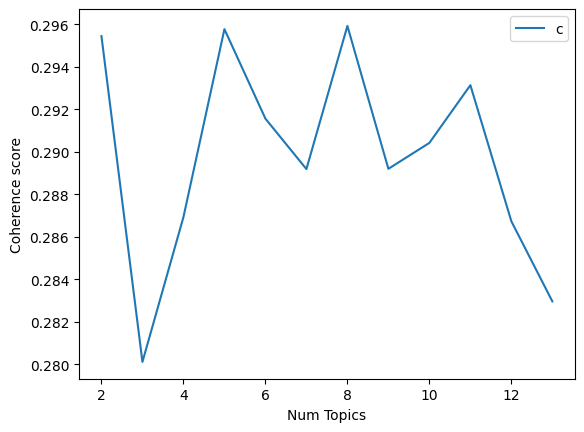

In [486]:
limit=14; start=2; step=1;
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=processed_passages, start=start, limit=limit, step=step)

# Show graph
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [320]:
# Build LDA model
lda_model = LdaModel(corpus=corpus,
                   id2word=id2word,
                   num_topics=5,
                    minimum_probability=0.001,
                    random_state=42)

pprint(lda_model.print_topics(num_words=15))
doc_lda = lda_model[corpus]

[(0,
  '0.005*"service" + 0.005*"company" + 0.003*"provide" + 0.003*"train" + '
  '0.003*"change" + 0.003*"plan" + 0.003*"build" + 0.003*"people" + '
  '0.003*"community" + 0.003*"programme" + 0.002*"example" + 0.002*"develop" + '
  '0.002*"ministry" + 0.002*"workers" + 0.002*"social"'),
 (1,
  '0.004*"provide" + 0.004*"service" + 0.004*"school" + 0.004*"community" + '
  '0.004*"build" + 0.004*"students" + 0.003*"company" + 0.003*"care" + '
  '0.003*"children" + 0.003*"efforts" + 0.003*"home" + 0.003*"system" + '
  '0.002*"learn" + 0.002*"centre" + 0.002*"sector"'),
 (2,
  '0.006*"service" + 0.004*"students" + 0.004*"build" + 0.003*"provide" + '
  '0.003*"company" + 0.003*"learn" + 0.003*"school" + 0.003*"plan" + '
  '0.002*"digital" + 0.002*"sector" + 0.002*"members" + 0.002*"community" + '
  '0.002*"people" + 0.002*"develop" + 0.002*"industry"'),
 (3,
  '0.004*"provide" + 0.004*"service" + 0.004*"community" + 0.003*"train" + '
  '0.003*"care" + 0.003*"school" + 0.003*"plan" + 0.003*"

In [321]:
LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word, sort_topics=False)

/Users/zhunhung/Desktop/GovTech/venv/lib/python3.9/site-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


In [322]:
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.005572 -0.002022       1        1  21.722188
1      0.004107 -0.001290       2        1  28.344037
2     -0.000400  0.003627       3        1  18.101569
3      0.001518 -0.003766       4        1  18.511839
4      0.000347  0.003451       5        1  13.320368, topic_info=            Term         Freq        Total Category  logprob  loglift
1653      school  1992.000000  1992.000000  Default  30.0000  30.0000
1682     service  3019.000000  3019.000000  Default  29.0000  29.0000
3584    students  1893.000000  1893.000000  Default  28.0000  28.0000
1372        plan  1749.000000  1749.000000  Default  27.0000  27.0000
2507     digital  1232.000000  1232.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
1872  technology   180.462327  1314.193967   Topic5  -6.1829   0.0304
986        issue   175.743281  1301.200059   Topic5  -6.2094   0.0139
3584    students   198.155297  1893.117314   Topic5  -6.0894  -0.2411
1170    ministry   177.394603  1445.145259   Topic5  -6.2001  -0.0817
270       change   176.600714  1432.152076   Topic5  -6.2046  -0.0772

[471 rows x 6 columns], token_table=       Topic      Freq  Term
term                        
1          1  0.224394  able
1          2  0.244159  able
1          3  0.132544  able
1          4  0.222069  able
1          5  0.177887  able
...      ...       ...   ...
13696      1  0.265486    华侨
13696      2  0.265486    华侨
13696      3  0.265486    华侨
13696      4  0.265486    华侨
13696      5  0.265486    华侨

[1497 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5])

Construct Topic and Dominant Topic columns

In [323]:
topic_dist_df = pd.DataFrame(columns=[f'Topic {e}' for e in range(lda_model.num_topics)] + ['Dominant Topic(s)'])
for passage in corpus:
    topic_dist_arr = [0] * (lda_model.num_topics + 1)
    topic_dist = lda_model[passage]
    for topic in topic_dist:
        topic_dist_arr[topic[0]] = topic[1]
        
    dominant_topics = [f'Topic {topic[0]}' for topic in topic_dist if topic[1] >= 0.25]
    topic_dist_arr[-1] = dominant_topics
    topic_dist_df = pd.concat([topic_dist_df, pd.DataFrame([topic_dist_arr], columns=[f'Topic {e}' for e in range(lda_model.num_topics)]+ ['Dominant Topic(s)'])], axis=0)
topic_dist_df = topic_dist_df.reset_index(drop=True)
topic_dist_df.index = speech_document.index

In [324]:
# Naming of topics after observing keywords
topic_rename = {'Topic 0': 'Community, National Development and Technology',
               'Topic 1': 'Transport, Healthcare',
               'Topic 2': 'Education, Economic',
               'Topic 3': 'Social, Family',
               'Topic 4': 'Workforce, Defence',}

In [325]:
speech_document_dist = speech_document.join(topic_dist_df)
speech_document_dist = speech_document_dist.rename(columns=topic_rename)
speech_document_dist['Dominant Topic(s)'] = speech_document_dist['Dominant Topic(s)'].apply(lambda x: [topic_rename[e] for e in x])

Attempt to utilise Ministry title information and combine with LDA topics

In [326]:
def parse_titles(title):
    new_title = title.split('(')[-1].replace(')','')
    if 'Ministry' in new_title:
        return new_title.replace('Ministry of', '').strip()
    else:
        return new_title.strip()

In [327]:
# Unique Ministry Titles
unique_titles = list(set([parse_titles(title) for title in debate_speech_level['Title'].unique()]))

In [328]:
title_mapper = {
    'Defence': 'Workforce, Defence',
    'Trade and Industry': 'Education, Economic',
    'Transport': 'Transport, Healthcare',
    'National Development':'Community, National Development and Technology',
     'Social and Family Development': 'Social, Family',
     'Culture, Community and Youth': 'Community, National Development and Technology',
     'the Environment and Water resources': 'Community, National Development and Technology',
     'Home Affairs': 'Community, National Development and Technology',
     'Finance': 'Education, Economic',
     'Health': 'Transport, Healthcare',
     'the Environment and Water Resources': 'Community, National Development and Technology',
     'Foreign Affairs': 'Community, National Development and Technology' ,
     'Education': 'Education, Economic',
     'Environment and Water Resources': 'Community, National Development and Technology',
     'Manpower': 'Workforce, Defence',
     'Communications and Information': 'Community, National Development and Technology',
}

In [329]:
debate_meta_info = debate_speech_level[['Sitting No', 'Sitting Date', 'Title', 'MPs Speaking', 'content_id']].drop_duplicates()
debate_meta_info = debate_meta_info.set_index('content_id')

In [330]:
debate_meta_info = debate_meta_info.merge(speech_document_dist, left_on=debate_meta_info.index, right_on=speech_document_dist.index, how='right')

In [331]:
debate_meta_info['inferred_title_topic'] = [title_mapper.get(parse_titles(e), None) for e in debate_meta_info['Title']]

In [332]:
debate_meta_info.head()

,key_0,Sitting No,Sitting Date,Title,MPs Speaking,Passage,processed_passage,"Community, National Development and Technology","Transport, Healthcare","Education, Economic","Social, Family","Workforce, Defence",Dominant Topic(s),inferred_title_topic
0,sprs3topic_reportid=budget-1039,41,8-3-2017,Committee of Supply − Head L (Ministry of the ...,"[Dr Chia Shi-Lu, The Chairman, Assoc Prof Dr M...","Madam, regarding the recent announcement on ca...",madam regarding the recent announcement on car...,0.517938,0.295218,0.021893,0.006529,0.158422,"[Community, National Development and Technolog...","Community, National Development and Technology"
1,sprs3topic_reportid=budget-1112,95,28-2-2019,Committee of Supply − Head U (Prime Minister's...,"[Mr Louis Ng Kok Kwang (Nee Soon), Mr Louis Ng...","Mr Chairman, Singapore has one of the most dyn...",mr chairman singapore has one of the most dyna...,0.063851,0.068364,0.660477,0.182951,0.024358,"[Education, Economic]",None
2,sprs3topic_reportid=budget-1113,95,28-2-2019,Committee of Supply - Head M (Ministry of Fina...,"[The Chairman, Mr Liang Eng Hwa, The Chairman,...","Mr Chairman, Sir, I beg to move, ""That the tot...",mr chairman sir i beg to move that the total s...,0.411155,0.174225,0.031387,0.035581,0.347652,"[Community, National Development and Technolog...","Education, Economic"
3,sprs3topic_reportid=budget-1114,95,28-2-2019,Committee of Supply - Head J (Ministry of Defe...,"[Mr Kwek Hian Chuan Henry (Nee Soon), Mr Kwek ...","Mr Chairman, I beg to move, ""That the total su...",mr chairman i beg to move that the total sum t...,0.497123,0.262817,0.133527,0.085086,0.021447,"[Community, National Development and Technolog...","Workforce, Defence"
4,sprs3topic_reportid=budget-1120,96,1-3-2019,Committee of Supply – Head J (Ministry of Defe...,"[Dr Ng Eng Hen, Dr Ng Eng Hen, The Chairman, M...","Thank you, Mr Chairman. Let me thank Members f...",thank you mr chairman let me thank members for...,0.343518,0.065882,0.543508,0.036315,0.010777,"[Community, National Development and Technolog...","Workforce, Defence"


In [333]:
# Adjust for dominant topic
inc_prob = 0.1
topic_names = list(topic_rename.values())
new_dominant_topics = []
for idx, row in debate_meta_info.iterrows():
    if (row['inferred_title_topic'] is None) or (row['inferred_title_topic'] in row['Dominant Topic(s)']):
        new_dominant_topics.append(row['Dominant Topic(s)'])
        continue
    else:
        debate_meta_info.loc[idx, row['inferred_title_topic']] += inc_prob
        # Normalise 
        new_total = sum(debate_meta_info.loc[idx, topic_names])
        for topic in topic_names:
            debate_meta_info.loc[idx, topic] = row[topic] / new_total
            
        # Update dominant topics
        dominant_topic = []
        for topic in topic_names:
            if debate_meta_info.loc[idx, topic] >= 0.25:
                dominant_topic.append(topic)
        new_dominant_topics.append(dominant_topic)

debate_meta_info['Dominant Topic(s)'] = new_dominant_topics
            

In [334]:
debate_meta_info.head()

,key_0,Sitting No,Sitting Date,Title,MPs Speaking,Passage,processed_passage,"Community, National Development and Technology","Transport, Healthcare","Education, Economic","Social, Family","Workforce, Defence",Dominant Topic(s),inferred_title_topic
0,sprs3topic_reportid=budget-1039,41,8-3-2017,Committee of Supply − Head L (Ministry of the ...,"[Dr Chia Shi-Lu, The Chairman, Assoc Prof Dr M...","Madam, regarding the recent announcement on ca...",madam regarding the recent announcement on car...,0.517938,0.295218,0.021893,0.006529,0.158422,"[Community, National Development and Technolog...","Community, National Development and Technology"
1,sprs3topic_reportid=budget-1112,95,28-2-2019,Committee of Supply − Head U (Prime Minister's...,"[Mr Louis Ng Kok Kwang (Nee Soon), Mr Louis Ng...","Mr Chairman, Singapore has one of the most dyn...",mr chairman singapore has one of the most dyna...,0.063851,0.068364,0.660477,0.182951,0.024358,"[Education, Economic]",None
2,sprs3topic_reportid=budget-1113,95,28-2-2019,Committee of Supply - Head M (Ministry of Fina...,"[The Chairman, Mr Liang Eng Hwa, The Chairman,...","Mr Chairman, Sir, I beg to move, ""That the tot...",mr chairman sir i beg to move that the total s...,0.373777,0.158386,0.028534,0.032347,0.316047,"[Community, National Development and Technolog...","Education, Economic"
3,sprs3topic_reportid=budget-1114,95,28-2-2019,Committee of Supply - Head J (Ministry of Defe...,"[Mr Kwek Hian Chuan Henry (Nee Soon), Mr Kwek ...","Mr Chairman, I beg to move, ""That the total su...",mr chairman i beg to move that the total sum t...,0.451930,0.238924,0.121388,0.077351,0.019498,"[Community, National Development and Technology]","Workforce, Defence"
4,sprs3topic_reportid=budget-1120,96,1-3-2019,Committee of Supply – Head J (Ministry of Defe...,"[Dr Ng Eng Hen, Dr Ng Eng Hen, The Chairman, M...","Thank you, Mr Chairman. Let me thank Members f...",thank you mr chairman let me thank members for...,0.312289,0.059893,0.494098,0.033014,0.009797,"[Community, National Development and Technolog...","Workforce, Defence"


Answer the question of evolution of parliamentary debates - Change in composition

In [335]:
debate_comp = debate_meta_info.copy()
debate_comp['Year'] = debate_comp['Sitting Date'].apply(lambda x: x[-4:])

In [336]:
topic_comp = []
year_comp = []
for idx, row in debate_comp.iterrows():
    for topic in row['Dominant Topic(s)']:
        topic_comp.append(topic)
        year_comp.append(row['Year'])
        
debate_comp = pd.DataFrame({'Year': year_comp, 'Topic': topic_comp})

In [337]:
agg_debate_comp = pd.DataFrame(debate_comp.groupby(['Year','Topic'])[['Topic']].count())
agg_debate_comp.columns = ['Count']
agg_debate_comp = agg_debate_comp.reset_index(names=['Year', 'Topic'])
agg_debate_comp_pivot = pd.pivot_table(data=agg_debate_comp, index=['Year'], columns=['Topic'], values='Count')
agg_debate_comp_pivot = agg_debate_comp_pivot.fillna(0)

In [339]:
# Underlying table for 100% stacked bar
agg_debate_comp_pivot_100 = agg_debate_comp_pivot.copy()
for idx, row in agg_debate_comp_pivot.iterrows():
    for col in agg_debate_comp_pivot.columns:
        agg_debate_comp_pivot_100.loc[idx, col] = row[col] / sum(row)


In [340]:
agg_debate_comp_pivot_100

Topic,"Community, National Development and Technology","Education, Economic","Social, Family","Transport, Healthcare","Workforce, Defence"
Year,,,,,
2016,0.161290,0.096774,0.258065,0.354839,0.129032
2017,0.266667,0.200000,0.233333,0.233333,0.066667
2018,0.416667,0.208333,0.041667,0.208333,0.125000
2019,0.368421,0.210526,0.000000,0.263158,0.157895
2020,0.208333,0.208333,0.125000,0.375000,0.083333


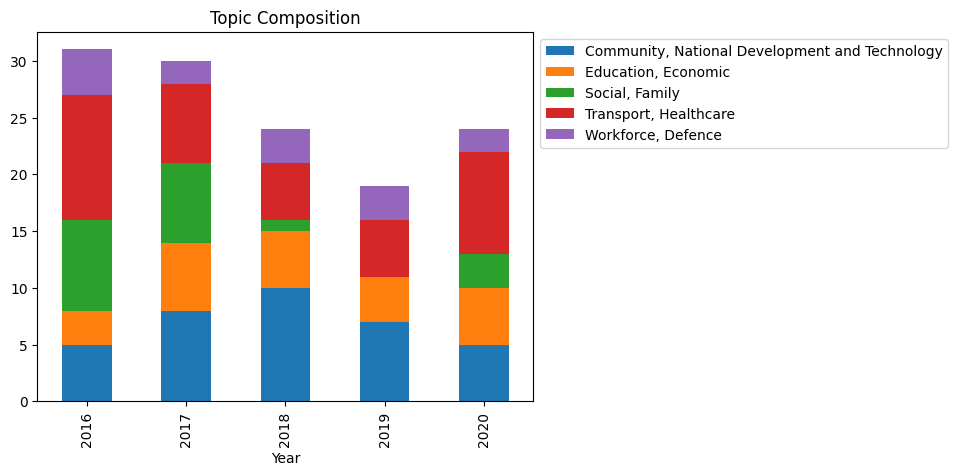

In [348]:
agg_debate_comp_pivot.plot.bar(stacked=True, title='Topic Composition').legend(bbox_to_anchor=(1.0, 1.0))

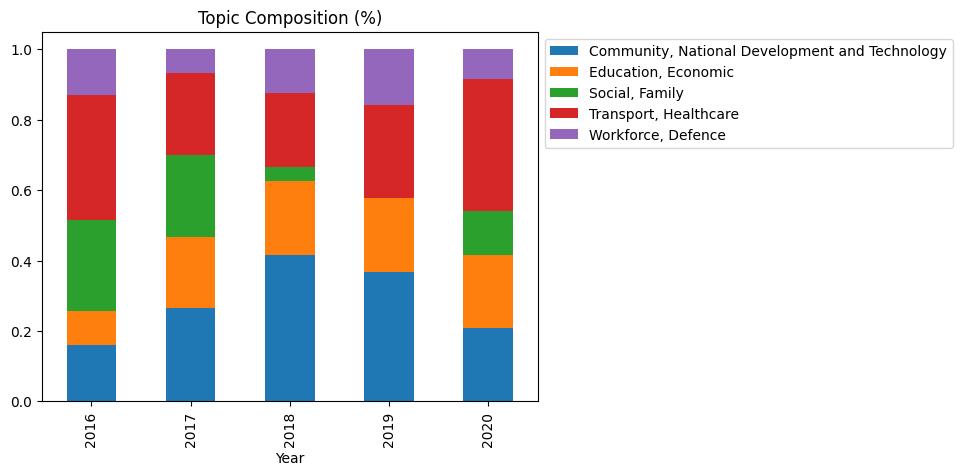

In [349]:
agg_debate_comp_pivot_100.plot.bar(stacked=True, title='Topic Composition (%)').legend(bbox_to_anchor=(1.0, 1.0))

The main limitation of LDA is that we have to provide our own labels for the topics. At this point, it appears to be force fitting due to the difficulty to provide clear distinct labels. Increasing the number of topics does not seem to resolve the issue and will only further increase the difficulty to distinguish between topic names. \
 \
However, one benefit of LDA is that it is able to capture the composition of topics per COS debate which I felt could be useful to breakdown across the years to observe the change in topics. This can also be done on the MP level which can be insightful.

### Approach 2: Word Embeddings

Steps:
1. Compute word embedding for each Topic name defined
2. Compute sentence/passage embedding
3. Calculate cosine similarity between sentence/passage embedding and each of the topic embedding
4. (Optional) Filter cosine similarity of topics below a certain threshold
5. Normalise row so it sums to 1 and utilise values as composition


In [147]:
import fasttext
import fasttext.util
import io
from scipy.spatial.distance import cdist
import numpy as np
# fasttext.util.download_model('en', if_exists='ignore')  # English

In [135]:
model = fasttext.load_model('cc.en.300.bin')

Crafted topics from Titles and Ministries Names

In [131]:
crafted_topics = [
    'Defence', 'Trade', 'Transport', 'Housing', 'Social', 'Family', 'Community', 'Youth',
    'Environment', 'Politics', 'Finance', 'Health', 'Education', 'Workforce', 'Technology'
]

In [142]:
topic_embedding_arr = [model.get_word_vector(topic) for topic in crafted_topics]
topic_embeddings = np.stack(topic_embedding_arr)

In [265]:
debate_embedding_df = debate_speech_level.copy()
debate_embedding_df['processed_passage'] = debate_embedding_df['Passage'].map(lambda x: re.sub(r'[^\w\s]', '', x)).map(lambda x: x.lower())
processed_passages = debate_embedding_df['processed_passage'].values.tolist()
processed_passages = list(sent_to_words(processed_passages))
# lemmatise words
processed_passages = [lemmatise_words(passage) for passage in processed_passages]

# remove stop words
processed_passages = remove_stopwords(processed_passages)

In [266]:
debate_embedding_df['processed_passage'] = [' '.join(e) for e in processed_passages]

Compute embedding of every paragraph

In [267]:
para_topic_dist = []
for idx, row in debate_embedding_df.iterrows():
    text = row['processed_passage']
    text_embedding = model.get_sentence_vector(text).reshape(1,-1)
    sim_score = 1 - cdist(text_embedding, topic_embeddings, metric='cosine')
    para_topic_dist.append(sim_score)

In [268]:
para_topic_dist_np = np.stack(para_topic_dist)
para_topic_dist_np = para_topic_dist_np.reshape(debate_embedding_df.shape[0], -1)
para_topic_df = pd.DataFrame(para_topic_dist_np, columns = crafted_topics)
debate_embedding_df = pd.concat([debate_embedding_df.reset_index(drop=True), para_topic_df.reset_index(drop=True)], axis=1)

Aggregate topic distribution by `content_id`

In [272]:
debate_topic_dist_id_level = debate_embedding_df.groupby('content_id')[crafted_topics].mean()

In [273]:
debate_topic_dist_id_level

,Defence,Trade,Transport,Housing,Social,Family,Community,Youth,Environment,Politics,Finance,Health,Education,Workforce,Technology
content_id,,,,,,,,,,,,,,,
sprs3topic_reportid=budget-1039,0.121181,0.112041,0.159850,0.152140,0.117193,0.080915,0.120600,0.095839,0.195317,0.080100,0.134665,0.150211,0.139345,0.098114,0.117875
sprs3topic_reportid=budget-1112,0.140300,0.099326,0.120120,0.138125,0.150987,0.116279,0.162930,0.121710,0.158845,0.090463,0.151976,0.158241,0.178109,0.136635,0.132936
sprs3topic_reportid=budget-1113,0.127160,0.104008,0.131512,0.155760,0.153096,0.084951,0.123622,0.081022,0.147299,0.081832,0.184199,0.136560,0.158101,0.137350,0.112549
sprs3topic_reportid=budget-1114,0.217590,0.113126,0.136554,0.090616,0.131637,0.085962,0.136844,0.112258,0.163274,0.091971,0.117414,0.141831,0.140911,0.113994,0.132083
sprs3topic_reportid=budget-1120,0.224258,0.116741,0.152222,0.109774,0.105026,0.092335,0.124807,0.091618,0.156599,0.079833,0.141681,0.135626,0.133818,0.093543,0.122339
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sprs3topic_reportid=budget-945,0.142625,0.113313,0.123465,0.154040,0.154646,0.083131,0.133652,0.084763,0.143555,0.072761,0.174171,0.135783,0.155593,0.138861,0.120638
sprs3topic_reportid=budget-946,0.107837,0.093166,0.120790,0.169731,0.111058,0.108235,0.133571,0.085175,0.145645,0.051121,0.119444,0.113003,0.128646,0.091228,0.088264
sprs3topic_reportid=budget-950,0.119709,0.122365,0.209345,0.125563,0.095205,0.059101,0.106754,0.070098,0.147570,0.053299,0.115273,0.115763,0.117910,0.096511,0.115116


Repeat the same composition analysis of Topics across Years

In [274]:
debate_emedding_comp = debate_embedding_df[['Sitting Date', 'content_id']].drop_duplicates()
debate_emedding_comp['Year'] = debate_emedding_comp['Sitting Date'].apply(lambda x: x[-4:])
debate_emedding_comp = debate_emedding_comp.merge(debate_topic_dist_id_level, left_on='content_id', right_on=debate_topic_dist_id_level.index)

Let's do a cut off of 0.15 and replace as 0. This is to keep only 'dominant' topics for each debate.

In [275]:
for col in crafted_topics:
    debate_emedding_comp[col] = debate_emedding_comp[col].apply(lambda x: 0 if x <=0.15 else x)

In [276]:
debate_emedding_comp_norm = debate_emedding_comp.copy()
for idx, row in debate_emedding_comp.iterrows():
    for col in crafted_topics:
        debate_emedding_comp_norm.loc[idx, col] = row[col] / sum(row[crafted_topics])

In [277]:
debate_emedding_comp_year = debate_emedding_comp_norm[['Year']+crafted_topics]
debate_emedding_comp_year = debate_emedding_comp_year.groupby('Year').mean()

In [278]:
debate_emedding_comp_year

,Defence,Trade,Transport,Housing,Social,Family,Community,Youth,Environment,Politics,Finance,Health,Education,Workforce,Technology
Year,,,,,,,,,,,,,,,
2016,0.085833,0.029008,0.072006,0.055431,0.045362,0.014136,0.110148,0.034794,0.209778,0.0,0.032812,0.102301,0.176281,0.014886,0.017222
2017,0.111931,0.019523,0.069062,0.098447,0.052435,0.000000,0.113468,0.036704,0.119680,0.0,0.071464,0.043862,0.205860,0.026385,0.031178
2018,0.074027,0.016842,0.090557,0.039926,0.056135,0.007394,0.074128,0.029263,0.276152,0.0,0.059617,0.037640,0.167689,0.026488,0.044141
2019,0.136420,0.000000,0.057450,0.107741,0.073004,0.026870,0.097479,0.011767,0.192345,0.0,0.042579,0.097954,0.145011,0.000000,0.011379
2020,0.074531,0.000000,0.000000,0.037059,0.051877,0.015742,0.123602,0.036634,0.261824,0.0,0.084139,0.078349,0.170455,0.038262,0.027526


In [279]:
debate_emedding_comp_year_100 = debate_emedding_comp_year.copy()
for idx, row in debate_emedding_comp_year.iterrows():
    for col in debate_emedding_comp_year.columns:
        debate_emedding_comp_year_100.loc[idx, col] = row[col] / sum(row)

In [281]:
debate_emedding_comp_year_100 # Copy to google sheets to plot chart for slide deck

,Defence,Trade,Transport,Housing,Social,Family,Community,Youth,Environment,Politics,Finance,Health,Education,Workforce,Technology
Year,,,,,,,,,,,,,,,
2016,0.085833,0.029008,0.072006,0.055431,0.045362,0.014136,0.110148,0.034794,0.209778,0.0,0.032812,0.102301,0.176281,0.014886,0.017222
2017,0.111931,0.019523,0.069062,0.098447,0.052435,0.000000,0.113468,0.036704,0.119680,0.0,0.071464,0.043862,0.205860,0.026385,0.031178
2018,0.074027,0.016842,0.090557,0.039926,0.056135,0.007394,0.074128,0.029263,0.276152,0.0,0.059617,0.037640,0.167689,0.026488,0.044141
2019,0.136420,0.000000,0.057450,0.107741,0.073004,0.026870,0.097479,0.011767,0.192345,0.0,0.042579,0.097954,0.145011,0.000000,0.011379
2020,0.074531,0.000000,0.000000,0.037059,0.051877,0.015742,0.123602,0.036634,0.261824,0.0,0.084139,0.078349,0.170455,0.038262,0.027526


100% Stacked plot to be used for presentation deck

## Individual MPs and their Questions

Assume each question asked is limited to one topic

In [ ]:
speaker_qns = []
speaker_qns_topic = []
speaker_qns_count = []
for idx, row in debate_embedding_df.iterrows():
    speaker = row['Speaker']
    topic_idx = np.argmax(row[crafted_topics])
    speaker_qns.append(speaker)
    speaker_qns_topic.append(crafted_topics[topic_idx])
    speaker_qns_count.append(row['Question Count'])


In [298]:
debate_speaker_qns = pd.DataFrame({'Speaker': speaker_qns, 'Topic': speaker_qns_topic, 'Questions': speaker_qns_count})
agg_speaker_qns = pd.DataFrame(debate_speaker_qns.groupby(['Speaker', 'Topic'])['Questions'].sum()).reset_index()

In [305]:
# Display top MP for each topic
top_mp_questions = []
for topic in crafted_topics:
    speaker = agg_speaker_qns[agg_speaker_qns['Topic']==topic].sort_values(by='Questions', ascending=False).iloc[0,0]
    top_mp_questions.append((speaker, topic))

In [307]:
top_mp_qns_df = pd.DataFrame(top_mp_questions, columns=['Top MP', 'Topic'])

MPs who asked questions frequently about each topic

In [309]:
top_mp_qns_df.sort_values(by='Topic')

,Top MP,Topic
6,Mr Kok Heng Leun,Community
0,Dr Ng Eng Hen,Defence
12,Ms Low Yen Ling,Education
8,Er Dr Lee Bee Wah,Environment
5,Mr Alex Yam,Family
10,Ms Indranee Rajah,Finance
11,Ms Tin Pei Ling,Health
3,Mr Chong Kee Hiong,Housing
9,Mr Cedric Foo Chee Keng,Politics
4,Prof Lim Sun Sun,Social
